### Getting Real Time Data

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt 

In [2]:
data = pdr.get_data_yahoo("SPY", start="2020-03-01", end="2021-03-30")
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-02,309.160004,294.459991,298.209991,309.089996,238703600.0,302.433044
2020-03-03,313.839996,297.570007,309.500000,300.239990,300139100.0,293.773682
2020-03-04,313.100006,303.329987,306.119995,312.859985,176613400.0,306.121857
2020-03-05,308.470001,300.010010,304.980011,302.459991,186366800.0,295.945862
2020-03-06,298.779999,290.230011,293.149994,297.459991,228667200.0,291.053558


In [3]:
data.to_csv('data.csv')

### Importing data to Spark

In [4]:
from pyspark import SparkFiles, SparkConf, SparkContext
from pyspark.sql import SparkSession

In [5]:
conf = SparkConf().setMaster("local").setAppName("Stock Analysis")
sc = SparkContext(conf = conf)

In [6]:
spark = SparkSession.builder.appName('data').getOrCreate()

In [7]:
data = spark.read.csv('data.csv', inferSchema=True, header=True)

In [8]:
data.show(5)

+----------+-----------------+------------------+-----------------+-----------------+----------+------------------+
|      Date|             High|               Low|             Open|            Close|    Volume|         Adj Close|
+----------+-----------------+------------------+-----------------+-----------------+----------+------------------+
|2020-03-02|309.1600036621094| 294.4599914550781|298.2099914550781|309.0899963378906|2.387036E8|302.43304443359375|
|2020-03-03|313.8399963378906|297.57000732421875|            309.5| 300.239990234375|3.001391E8|  293.773681640625|
|2020-03-04|313.1000061035156| 303.3299865722656|306.1199951171875|312.8599853515625|1.766134E8| 306.1218566894531|
|2020-03-05|308.4700012207031|  300.010009765625|304.9800109863281|302.4599914550781|1.863668E8|295.94586181640625|
|2020-03-06|298.7799987792969| 290.2300109863281|293.1499938964844|297.4599914550781|2.286672E8| 291.0535583496094|
+----------+-----------------+------------------+-----------------+-----

In [9]:
data

DataFrame[Date: string, High: double, Low: double, Open: double, Close: double, Volume: double, Adj Close: double]

In [10]:
data.printSchema()

root
 |-- Date: string (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Adj Close: double (nullable = true)



In [11]:
# Data summary
data.describe().show()

+-------+----------+------------------+------------------+------------------+------------------+-------------------+------------------+
|summary|      Date|              High|               Low|              Open|             Close|             Volume|         Adj Close|
+-------+----------+------------------+------------------+------------------+------------------+-------------------+------------------+
|  count|       273|               273|               273|               273|               273|                273|               273|
|   mean|      null| 337.1476186675466|331.44468873411745|334.40963303562484| 334.4653120215559|9.845714102564102E7| 331.3625758244441|
| stddev|      null| 39.91508985376503|41.791686242239294|40.986074008202074|40.883187592147515|6.300305710048807E7|42.086985194120444|
|    min|2020-03-02|229.67999267578125|218.25999450683594|228.19000244140625| 222.9499969482422|          2.64579E7|219.43106079101562|
|    max|2021-03-30| 398.1199951171875| 395.0799

In [12]:
# Summary with 2 decimal points
from pyspark.sql.functions import format_number
summary = data.describe()
summary.select(summary['summary'],
                  format_number(summary['Open'].cast('float'), 2).alias('Open'),
                  format_number(summary['High'].cast('float'), 2).alias('High'),
                  format_number(summary['Low'].cast('float'), 2).alias('Low'),
                  format_number(summary['Close'].cast('float'), 2).alias('Close'),
                  format_number(summary['Volume'].cast('int'),0).alias('Volume')
                 ).show()

+-------+------+------+------+------+------+
|summary|  Open|  High|   Low| Close|Volume|
+-------+------+------+------+------+------+
|  count|273.00|273.00|273.00|273.00|   273|
|   mean|334.41|337.15|331.44|334.47|  null|
| stddev| 40.99| 39.92| 41.79| 40.88|  null|
|    min|228.19|229.68|218.26|222.95|  null|
|    max|397.07|398.12|395.08|397.26|  null|
+-------+------+------+------+------+------+



### Querrying

In [13]:
# 1. ratio of the High Price versus volume of stock traded for a day
high_volume_ratio = data.withColumn('High-Volume-Ratio', data['High']/data['Volume']).select(['High-Volume-Ratio'])
high_volume_ratio.show(10)

+--------------------+
|   High-Volume-Ratio|
+--------------------+
|1.295162719213741...|
|1.045648488777005...|
|1.772798701024472...|
|1.655176786963682E-6|
|1.306615022964801...|
|9.184683676103639E-7|
|1.043682932692981...|
|1.104277331456731...|
|6.798723363201111E-7|
|8.237498061430715E-7|
+--------------------+
only showing top 10 rows



In [14]:
# 2. Difference between high and low stock traded for a day
high_low_diff = data.withColumn('High-Low-Difference', data['High']-data['Low']).select(['High-Low-Difference'])
high_low_diff.show(10)

+-------------------+
|High-Low-Difference|
+-------------------+
|  14.70001220703125|
| 16.269989013671875|
|      9.77001953125|
|  8.459991455078125|
|   8.54998779296875|
|    10.739990234375|
| 15.019989013671875|
|  11.05999755859375|
| 18.980010986328125|
| 22.960006713867188|
+-------------------+
only showing top 10 rows



In [15]:
# 3. Date with peak high price
data.orderBy(data['High'].desc()).select(['Date']).head(1)[0]['Date']

'2021-03-17'

In [16]:
# 4. Date with least price
data.orderBy(data['Low'].asc()).select(['Date']).head(1)[0]['Date']

'2020-03-23'

In [17]:
# 5. Days close was less than mean of close
from pyspark.sql.functions import mean

close_mean = data.select(mean('Close')).collect()[0][0]
print("Number of such days: ", data.filter(data['Close'] < close_mean).count())
date = data.filter(data['Close'] < close_mean)
date = date.select(['Date'])
date.show(10)

Number of such days:  128
+----------+
|      Date|
+----------+
|2020-03-02|
|2020-03-03|
|2020-03-04|
|2020-03-05|
|2020-03-06|
|2020-03-09|
|2020-03-10|
|2020-03-11|
|2020-03-12|
|2020-03-13|
+----------+
only showing top 10 rows



In [18]:
# 6. Correlation 
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=data.columns[1:], outputCol=vector_col)
df_vector = assembler.transform(data).select(vector_col)
#print(df_vector.collect()[0])
matrix = Correlation.corr(df_vector, vector_col)
matrix.collect()[0]["pearson({})".format(vector_col)].values

array([ 1.        ,  0.99661573,  0.99819426,  0.99736177, -0.5714096 ,
        0.99749978,  0.99661573,  1.        ,  0.9977581 ,  0.9976978 ,
       -0.62439473,  0.99754788,  0.99819426,  0.9977581 ,  1.        ,
        0.99627913, -0.59324518,  0.99624603,  0.99736177,  0.9976978 ,
        0.99627913,  1.        , -0.60543009,  0.99980344, -0.5714096 ,
       -0.62439473, -0.59324518, -0.60543009,  1.        , -0.60255489,
        0.99749978,  0.99754788,  0.99624603,  0.99980344, -0.60255489,
        1.        ])

In [19]:
# 7. Maximum high per year
from pyspark.sql.functions import (dayofmonth, hour,
                                   dayofyear, month,
                                   year, weekofyear,
                                  format_number, date_format)

year_df = data.withColumn('Year', year(data['Date']))
year_df.groupBy('Year').max()['Year', 'max(High)'].show()

+----+-----------------+
|Year|        max(High)|
+----+-----------------+
|2020|378.4599914550781|
|2021|398.1199951171875|
+----+-----------------+



In [20]:
# 8. Average Close for each month
month_df = data.withColumn('Month', month(data['Date']))
month_df = month_df.groupBy('Month').mean()
month_df = month_df.orderBy('Month')
month_df['Month', 'avg(Close)'].show()

+-----+------------------+
|Month|        avg(Close)|
+-----+------------------+
|    1| 378.1784234297903|
|    2|387.48157701994245|
|    3|327.40204655040395|
|    4| 275.4090496244885|
|    5| 291.6530014038086|
|    6|310.15408602627843|
|    7| 319.9940906871449|
|    8| 338.7480948311942|
|    9|336.03524198986236|
|   10|340.97909407182175|
|   11| 354.4200012207031|
|   12| 368.8863636363636|
+-----+------------------+



In [21]:
# 9. Daily returns
daily_returns = data.withColumn('Daily-Returns', (data.Close - data.Open) * data.Volume)
daily_returns.select(daily_returns['Date'],
                  format_number(daily_returns['Daily-Returns'].cast('float'), 2).alias('Daily-Returns')).show(10)

+----------+-----------------+
|      Date|    Daily-Returns|
+----------+-----------------+
|2020-03-02| 2,597,096,448.00|
|2020-03-03|-2,779,290,880.00|
|2020-03-04| 1,190,372,608.00|
|2020-03-05|  -469,647,968.00|
|2020-03-06|   985,555,072.00|
|2020-03-09|  -331,069,344.00|
|2020-03-10| 1,044,958,336.00|
|2020-03-11|-1,618,712,192.00|
|2020-03-12|-3,094,621,184.00|
|2020-03-13| 2,053,200,384.00|
+----------+-----------------+
only showing top 10 rows



In [22]:
# 10. Maximum daily returns month wise
month_dr = data.withColumn('Monthly-Daily-Returns', (data.Close - data.Open) * data.Volume)
month_dr = month_dr.withColumn('Month', month(data['Date']))
month_dr = month_dr.orderBy('Month')
month_dr = month_dr.groupBy("Month").agg({"Monthly-Daily-Returns":"avg"})
month_dr.select(month_dr['Month'],
                  format_number(month_dr['avg(Monthly-Daily-Returns)'].cast('float'), 2).alias('Monthly-Daily-Returns')).show()

+-----+---------------------+
|Month|Monthly-Daily-Returns|
+-----+---------------------+
|    1|       -56,558,216.00|
|    2|       -36,988,192.00|
|    3|        57,332,024.00|
|    4|        29,616,842.00|
|    5|       -15,848,993.00|
|    6|      -117,272,408.00|
|    7|         6,991,015.00|
|    8|        23,680,168.00|
|    9|      -143,756,192.00|
|   10|       -58,093,488.00|
|   11|       -48,085,224.00|
|   12|         6,502,654.50|
+-----+---------------------+



### Predictions with ML Models

#### Pre processing

In [23]:
from pyspark.ml.feature import VectorAssembler

cols = data.columns[1:]
cols.pop(3)
assembler = VectorAssembler(
    inputCols=cols,
    outputCol="features")

output = assembler.transform(data).select('features','Close')

In [24]:
output.show(5)

+--------------------+-----------------+
|            features|            Close|
+--------------------+-----------------+
|[309.160003662109...|309.0899963378906|
|[313.839996337890...| 300.239990234375|
|[313.100006103515...|312.8599853515625|
|[308.470001220703...|302.4599914550781|
|[298.779998779296...|297.4599914550781|
+--------------------+-----------------+
only showing top 5 rows



#### Splitting into train and test

In [25]:
train,test = output.randomSplit([0.75, 0.25])

In [26]:
r2_values = []

#### 1. Linear Regression

In [27]:
from pyspark.ml.regression import LinearRegression
lin_reg = LinearRegression(featuresCol='features', labelCol='Close')
linear_model = lin_reg.fit(train)
print("Coefficients: " + str(linear_model.coefficients))
print("Intercept: " + str(linear_model.intercept))

Coefficients: [-0.0013771496386270948,0.04565000606127597,0.0003478975003128736,-1.384744684504912e-09,0.9238933499584007]
Intercept: 13.738688724318092


In [28]:
trainSummary = linear_model.summary
print("Validation set: ")
print(" RMSE: %f" % trainSummary.rootMeanSquaredError)
print(" R2: %f" % trainSummary.r2)

Validation set: 
 RMSE: 0.784138
 R2: 0.999614


In [29]:
from  pyspark.sql.functions import abs
predictions = linear_model.transform(test)
x = ((predictions['Close'] - predictions['Prediction'])/predictions['Close'])*100
predictions = predictions.withColumn('Accuracy',abs(x))
predictions.select("Prediction","Close","Accuracy","features").show(10)

+------------------+------------------+--------------------+--------------------+
|        Prediction|             Close|            Accuracy|            features|
+------------------+------------------+--------------------+--------------------+
|225.74477798544387| 222.9499969482422|  1.2535461204112488|[229.679992675781...|
|244.92994007437014|243.14999389648438|  0.7320362831855689|[244.100006103515...|
|240.39317698098384|             240.0| 0.16382374207659942|[248.369995117187...|
|250.16557263201736|248.19000244140625|  0.7959910436269525|[253.320007324218...|
|255.05500974096992| 253.4199981689453|  0.6451785904183499|[260.809997558593...|
|274.52604629133265| 274.0299987792969|  0.1810194191312931|[276.0,265.25,267...|
| 279.7487039637771| 279.1000061035156| 0.23242488214810494|[281.0,276.910003...|
|278.42059654435917|  277.760009765625| 0.23782645287619936|[283.940002441406...|
| 283.8887808857143| 283.7900085449219|0.034804728080059036|[284.899993896484...|
| 282.0388268209

In [30]:
predicted = [predictions.collect()[i]['prediction'] for i in range(predictions.count())]
actual = [predictions.collect()[i]['Close'] for i in range(predictions.count())]

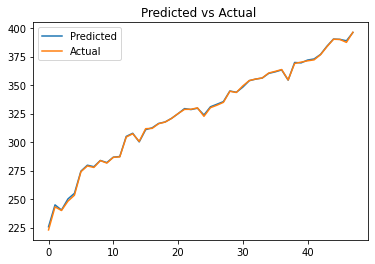

In [31]:
plt.plot(predicted)
plt.plot(actual)
plt.title('Predicted vs Actual ')
plt.legend(['Predicted', 'Actual'])
plt.show()

In [32]:
from pyspark.ml.evaluation import RegressionEvaluator
pred_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close",metricName="r2")

In [33]:
r2 = trainSummary.r2
n = data.count()
p = len(data.columns)
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)

In [34]:
r2_values.append(r2)

In [35]:
print("Test Data:")
print(" R2: %g" % pred_evaluator.evaluate(predictions))
print(" Adjusted R2: ", adjusted_r2)

Test Data:
 R2: 0.999664
 Adjusted R2:  0.9996041310158508


#### 2. Decision tree

In [36]:
cols = data.columns[1:]
cols.pop(3)

'Close'

In [37]:
cols

['High', 'Low', 'Open', 'Volume', 'Adj Close']

In [38]:
from pyspark.ml.regression import DecisionTreeRegressor
va = VectorAssembler(inputCols=cols, outputCol='features')
dt = DecisionTreeRegressor(maxDepth=5, featuresCol='features',labelCol='Close')
dt_model = dt.fit(train)

In [39]:
result = dt_model.transform(test)
result.show(10)

+--------------------+------------------+------------------+
|            features|             Close|        prediction|
+--------------------+------------------+------------------+
|[229.679992675781...| 222.9499969482422|240.88750076293945|
|[244.100006103515...|243.14999389648438|246.48666381835938|
|[248.369995117187...|             240.0|240.88750076293945|
|[253.320007324218...|248.19000244140625|246.48666381835938|
|[260.809997558593...| 253.4199981689453| 263.3183339436849|
|[276.0,265.25,267...| 274.0299987792969| 263.3183339436849|
|[281.0,276.910003...| 279.1000061035156| 279.0899963378906|
|[283.940002441406...|  277.760009765625|275.09800415039064|
|[284.899993896484...| 283.7900085449219|283.69571794782365|
|[287.190002441406...| 281.6000061035156|283.69571794782365|
+--------------------+------------------+------------------+
only showing top 10 rows



In [40]:
result.collect()[0]

Row(features=DenseVector([229.68, 218.26, 228.19, 326025200.0, 219.4311]), Close=222.9499969482422, prediction=240.88750076293945)

In [41]:
predicted = [result.collect()[i]['prediction'] for i in range(result.count())]
actual = [result.collect()[i]['Close'] for i in range(result.count())]

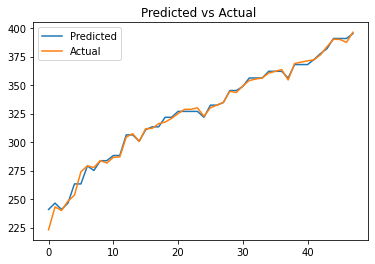

In [42]:
plt.plot(predicted)
plt.plot(actual)
plt.title('Predicted vs Actual ')
plt.legend(['Predicted', 'Actual'])
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(actual, predicted, squared=True)
r2 = r2_score(actual, predicted)

In [44]:
r2_values.append(r2)

In [45]:
print("Test Data:")
print(" MSE: ", mse)
print(" R2: ", r2)

Test Data:
 MSE:  14.076103030583392
 R2:  0.9926435111181677


#### 3. Random Forest

In [46]:
from pyspark.ml.regression import RandomForestRegressor

In [47]:
rf = RandomForestRegressor(numTrees=100, featuresCol='features',labelCol='Close')
rf_model = rf.fit(train)

In [48]:
results = rf_model.transform(test)

In [49]:
results.show(10)

+--------------------+------------------+------------------+
|            features|             Close|        prediction|
+--------------------+------------------+------------------+
|[229.679992675781...| 222.9499969482422|241.97138848815564|
|[244.100006103515...|243.14999389648438|244.22381723941984|
|[248.369995117187...|             240.0|241.97138848815564|
|[253.320007324218...|248.19000244140625| 249.2036180063634|
|[260.809997558593...| 253.4199981689453|  261.746825323108|
|[276.0,265.25,267...| 274.0299987792969|265.53574783122673|
|[281.0,276.910003...| 279.1000061035156| 278.5724442145389|
|[283.940002441406...|  277.760009765625| 278.2128453615003|
|[284.899993896484...| 283.7900085449219|283.02339843126606|
|[287.190002441406...| 281.6000061035156|284.67589420358917|
+--------------------+------------------+------------------+
only showing top 10 rows



In [50]:
results.collect()[0]

Row(features=DenseVector([229.68, 218.26, 228.19, 326025200.0, 219.4311]), Close=222.9499969482422, prediction=241.97138848815564)

In [51]:
predicted = [results.collect()[i]['prediction'] for i in range(results.count())]
actual = [results.collect()[i]['Close'] for i in range(results.count())]

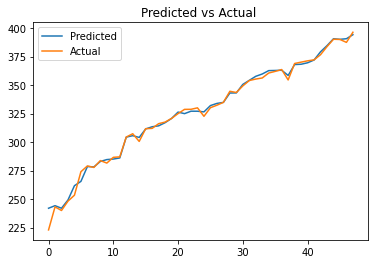

In [52]:
plt.plot(predicted)
plt.plot(actual)
plt.title('Predicted vs Actual ')
plt.legend(['Predicted', 'Actual'])
plt.show()

In [53]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(actual, predicted, squared=True)
r2 = r2_score(actual, predicted)

In [54]:
r2_values.append(r2)

In [55]:
print("Test Data:")
print(" MSE: ", mse)
print(" R2: ", r2)

Test Data:
 MSE:  13.869213721484252
 R2:  0.9927516361367791


### Comparing models wrt R2 score

In [56]:
r2_values

[0.9996143188205899, 0.9926435111181677, 0.9927516361367791]

In [57]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest']

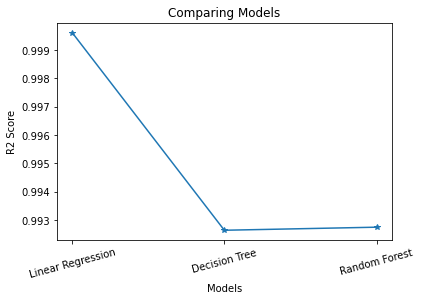

In [58]:
plt.plot(models, r2_values, '*-')
plt.title('Comparing Models')
plt.xlabel('Models')
plt.xticks(rotation=15)
plt.ylabel('R2 Score')
plt.show()